<a href="https://colab.research.google.com/github/KaiXiangC/Python_Factor-Investing_Final-Project/blob/main/m1215498_%E9%99%B3%E9%B4%BB%E7%A2%A9_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **策略715-盈餘加速成長**

# 1.0 安裝套件 & 環境

In [ ]:
!pip install xgboost
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!pip install mpl_finance
!pip install mglearn
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 9.8 MB/s eta 0:00:00
--2024-01-05 04:36:20--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.253.62.102, 172.253.62.101, 172.253.62.100, ...
Connecting to drive.google.com (drive.google.com)|172.253.62.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6kuqi7i2pggc5knoc26fog5u2q8q9g0d/1704429375000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=9907452d-20fe-47ca-af1a-59d6a99b123e [following]
--2024-01-05 04:36:24--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6kuqi7i2pggc5knoc26fog5u2q8q9g0d/1704429375000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=9907452d-20fe-47ca-af1a-59d6a99b123e
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.goo

In [ ]:
import pandas as pd
import numpy as np
import warnings
from pandas.tseries.offsets import MonthEnd
#------------------機器學習套件-------------------#
import sklearn
# 模型套件
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# 特徵選擇套件
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.feature_selection import chi2,f_classif,mutual_info_classif
from xgboost import XGBClassifier
# 混淆矩陣
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt #繪圖套件
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
import seaborn as sns
import xgboost
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectFromModel
#-----------------中文字體------------------------#
import matplotlib as mpl
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

plt.style.use('ggplot')
plt.rcParams.update({
    'font.weight': 'bold',
    'text.color': 'k',
    'axes.labelcolor': 'k',
    'xtick.color': 'k',
    'ytick.color': 'k'})
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_price1 = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//價量資料.feather')
df_price2 = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//季財報資料.feather')
df_price3 = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//月營收資料.feather')

# 2.0 因子計算

In [ ]:
# 證券名稱、資料日、收盤價、普通股股本、月營收
df_1 = df_price1[['證券名稱','資料日','收盤價']]
df_2 = df_price2[['證券名稱','編表日','普通股股本','營業利益']]
df_3 = df_price3[['證券名稱','營收發布日','單月營收(千元)']]

df_2['營業利益_QoQ'] = df_2.groupby('證券名稱').apply(lambda x: (x['營業利益'] - x['營業利益'].shift(1)) / x['營業利益'].shift(1)).reset_index(level=0,drop=True)
df_3['月營收_YoY'] = df_3.groupby('證券名稱').apply(lambda x: (x['單月營收(千元)'] - x['單月營收(千元)'].shift(12)) / x['單月營收(千元)'].shift(12)).reset_index(level=0,drop=True)

# 3.0 合併各類因子資料
- 根據前一部份計算整理，列出想要放入模型的因子 (需保留`收盤價`欄位)
- 合併部份基本無需更動，確認最後產出之dataframe無缺失值、重複值、inf(無限大值)，且資料合理即可

In [ ]:
# 將價量以外因子(籌碼、月營收、財報因子)，mapping至日頻率
df_3.drop_duplicates(subset=['證券名稱','營收發布日'],inplace=True)
df_3 = df_3.reset_index(drop=True)

df_2.drop_duplicates(subset=['證券名稱','編表日'],inplace=True)
df_2 = df_2.reset_index(drop=True)

df_1['資料日'] = pd.to_datetime(df_1['資料日'])
df_1.set_index('資料日', inplace=True)
df_1 = df_1.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_1 = df_1.sort_values(by=['證券名稱','資料日']).reset_index()

df_3['營收發布日'] = pd.to_datetime(df_3['營收發布日'])
df_3.set_index('營收發布日', inplace=True)
df_3 = df_3.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_3 = df_3.sort_values(by=['證券名稱','營收發布日']).reset_index()

df_2['編表日'] = pd.to_datetime(df_2['編表日'])
df_2.set_index('編表日', inplace=True)
df_2 = df_2.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_2 = df_2.sort_values(by=['證券名稱','編表日']).reset_index()

In [ ]:
# 以價量資料(台股交易日)為基準，合併不同頻率之資料
df_all_factor = df_1.copy()

# merge: 合併兩個dataframe，on=合併基準欄位，how=以哪個dataframe為準)
df_all_factor = pd.merge(df_all_factor, df_3, left_on=['證券名稱', '資料日'], right_on=['證券名稱', '營收發布日'], how='left')
df_all_factor = pd.merge(df_all_factor, df_2, left_on=['證券名稱', '資料日'], right_on=['證券名稱', '編表日'], how='left')

df_all_factor.drop(columns=['營收發布日','編表日'],inplace=True)

In [ ]:
# 把inf(除以0)填補成缺失值，以利後續一併刪除
df_all_factor.replace([np.inf, -np.inf], np.NaN, inplace=True)

# 刪除含有缺失值之資料行
df_all_factor.dropna(inplace=True)
df_all_factor = df_all_factor.sort_values(by=['證券名稱','資料日']).reset_index(level=0,drop=True)
df_all_factor

,資料日,證券名稱,收盤價,單月營收(千元),月營收_YoY,普通股股本,營業利益,營業利益_QoQ
0,2019-02-15,1101台泥,23.839509,9394240.0,-0.023203,51080599.0,7346632.0,-0.181794
1,2019-02-16,1101台泥,23.839509,9394240.0,-0.023203,51080599.0,7346632.0,-0.181794
2,2019-02-17,1101台泥,23.839509,9394240.0,-0.023203,51080599.0,7346632.0,-0.181794
3,2019-02-18,1101台泥,23.489396,9394240.0,-0.023203,51080599.0,7346632.0,-0.181794
4,2019-02-19,1101台泥,23.903166,9394240.0,-0.023203,51080599.0,7346632.0,-0.181794
...,...,...,...,...,...,...,...,...
2754334,2023-11-09,9962有益,17.450000,235016.0,-0.235536,902203.0,35040.0,-0.354696
2754335,2023-11-10,9962有益,17.400000,235016.0,-0.235536,902203.0,35040.0,-0.354696
2754336,2023-11-11,9962有益,17.400000,235016.0,-0.235536,902203.0,35040.0,-0.354696
2754337,2023-11-12,9962有益,17.400000,235016.0,-0.235536,902203.0,35040.0,-0.354696


In [ ]:
df_all_factor.isnull().sum()

資料日         0
證券名稱        0
收盤價         0
單月營收(千元)    0
月營收_YoY     0
普通股股本       0
營業利益        0
營業利益_QoQ    0
dtype: int64

In [ ]:
# 依據各指標特性，制定篩選規則
df_select = df_all_factor.copy()

# 2.收盤價<100、連續三季營業利益成長、連續兩個月YoY>1%
df_select = df_select[(df_all_factor['收盤價']<100) & (df_all_factor['月營收_YoY']>1) & (df_all_factor['月營收_YoY'].shift(1)>1) & (df_all_factor['營業利益']>=df_all_factor['營業利益'].shift(1))& (df_all_factor['營業利益'].shift(1)>=df_all_factor['營業利益'].shift(2))]

df_select.reset_index(drop=True, inplace=True)

# 抽樣驗證
df_select[df_select['資料日']=='2023-10-01']

,資料日,證券名稱,收盤價,單月營收(千元),月營收_YoY,普通股股本,營業利益,營業利益_QoQ
5991,2023-10-01,1456怡華,16.45,73476.0,1.022962,937200.0,220056.0,9.806128
6996,2023-10-01,1472三洋實業,41.90,175397.0,3.353039,249881.0,15828.0,1.889903
7861,2023-10-01,1512瑞利,11.85,90778.0,1.024848,981835.0,-33869.0,2.002305
8184,2023-10-01,1515力山,42.95,955059.0,1.275868,1814735.0,-16686.0,-0.785350
12852,2023-10-01,1786科妍,83.50,80500.0,1.077956,669800.0,38812.0,-0.067131
...,...,...,...,...,...,...,...,...
112248,2023-10-01,6733博晟生醫,36.00,7008.0,1.040175,1230760.0,-26091.0,-0.552531
113099,2023-10-01,8034榮群,21.85,52271.0,3.025491,628737.0,24686.0,5.219703
113956,2023-10-01,8048德勝,75.60,182632.0,1.226405,544712.0,75154.0,0.706998
115949,2023-10-01,8087華鎂鑫,53.90,14148.0,6.553657,290690.0,-12012.0,0.125035


In [ ]:
# 每日選股名單
df_select_d = df_select[['資料日','證券名稱','收盤價']].sort_values(by=['資料日','證券名稱'])

# 每月第一個交易日之選股名單
df_select_d['年月'] = df_select_d['資料日'].dt.strftime('%Y-%m')
reb_date = df_select_d[['年月','資料日']].sort_values(by='資料日').drop_duplicates(subset=['年月'], keep = 'first').reset_index(drop=True)
df_select_m = df_select_d[df_select_d['資料日'].isin(reb_date['資料日'])].copy().reset_index(drop=True)

df_select_m[df_select_m['資料日']=='2023-11-01'].head(10)

,資料日,證券名稱,收盤價,年月
4087,2023-11-01,1314中石化,10.30,2023-11
4088,2023-11-01,1437勤益控,29.55,2023-11
4089,2023-11-01,1442名軒,35.75,2023-11
4090,2023-11-01,1456怡華,16.25,2023-11
4091,2023-11-01,1515力山,39.60,2023-11
4092,2023-11-01,1516川飛,16.25,2023-11
4093,2023-11-01,1529樂事綠能,29.30,2023-11
4094,2023-11-01,1603華電,33.50,2023-11
4095,2023-11-01,1799易威,28.80,2023-11
4096,2023-11-01,1808潤隆,95.00,2023-11


# 4.0 選股模型

1.   XGBClassifier
2.   XGBRegressor



In [ ]:
# 特徵集合(因子集合)
feature_list = df_all_factor.columns.drop(['證券名稱','資料日','收盤價','普通股股本'])

feature_list_std = df_all_factor.columns.drop(['證券名稱','資料日','收盤價','普通股股本','月營收_YoY','營業利益_QoQ'])

feature_list_nor = df_all_factor.columns.drop(['證券名稱','資料日','收盤價','普通股股本','單月營收(千元)','營業利益'])

# 取每月第一個交易日的資料
df_feature = df_all_factor.copy()
df_feature['年月'] = df_feature['資料日'].dt.strftime('%Y-%m')
reb_date_all = df_feature[['年月','資料日']].sort_values(by='資料日').drop_duplicates(subset=['年月'], keep = 'first').reset_index(drop=True)
df_feature_m = df_feature[df_feature['資料日'].isin(reb_date_all['資料日'])].copy().reset_index(drop=True)

In [ ]:
# 因子標準化
def standardize(x):
    return (x - x.mean()) / x.std()

# 因子歸一化
def normalized(x):
    return (x-x.min())/(x.max()-x.min())

df_feature_m[feature_list_std] = df_feature_m.groupby('資料日')[feature_list_std].apply(standardize).reset_index(level=0,drop=True)

df_feature_m[feature_list_nor] = df_feature_m.groupby('資料日')[feature_list_nor].apply(normalized).reset_index(level=0,drop=True)

df_feature_m.head()

,資料日,證券名稱,收盤價,單月營收(千元),月營收_YoY,普通股股本,營業利益,營業利益_QoQ,年月
0,2019-03-01,1101台泥,24.444250,0.604688,0.614589,51080599.0,2.138930,0.934685,2019-03
1,2019-04-01,1101台泥,26.322128,0.448883,0.010544,53080599.0,2.033372,0.416884,2019-04
2,2019-05-01,1101台泥,26.735898,0.802731,0.014140,53080599.0,2.037005,0.416884,2019-05
3,2019-06-01,1101台泥,27.308810,0.775974,0.000238,51080599.0,2.350363,0.027063,2019-06
4,2019-07-01,1101台泥,29.377659,0.787658,0.000304,51080599.0,2.348776,0.027063,2019-07


In [ ]:
# 計算個股下期報酬，作為模型訓練答案
df_feature_m['下期報酬率'] = df_feature_m.groupby('證券名稱').apply(lambda x:x['收盤價'].shift(-1) / x['收盤價'] - 1).reset_index(level=0,drop=True)

df_feature_m['下期報酬'] = df_feature_m.groupby('證券名稱').apply(lambda x:(x['收盤價'].shift(-1)-x['收盤價'])).reset_index(level=0,drop=True)
df_feature_m['下期報酬'] = df_feature_m['下期報酬'].apply(lambda x: 1 if x>0 else 0)
df_feature_m.dropna(inplace=True)
df_feature_m[df_feature_m['證券名稱'] == '1101台泥'].tail()

,資料日,證券名稱,收盤價,單月營收(千元),月營收_YoY,普通股股本,營業利益,營業利益_QoQ,年月,下期報酬率,下期報酬
51,2023-06-01,1101台泥,37.23777,0.585962,0.006584,71561817.0,-0.046479,0.915582,2023-06,0.007947,1
52,2023-07-01,1101台泥,37.53370,0.585032,0.012648,71561817.0,-0.046385,0.915582,2023-07,0.000434,1
53,2023-08-01,1101台泥,37.55000,0.542795,0.881819,71561817.0,-0.047155,0.915582,2023-08,-0.061252,0
54,2023-09-01,1101台泥,35.25000,0.510289,0.005675,71561817.0,0.545483,0.624310,2023-09,-0.056738,0
55,2023-10-01,1101台泥,33.25000,0.577062,0.006144,71561817.0,0.546092,0.624310,2023-10,-0.034586,0


In [ ]:
# 切分訓練期和測試期
train_start_st = '2020-01-01'
test_start_st= '2022-01-01'
test_end_dt = '2023-10-31'

0.0962426755662238


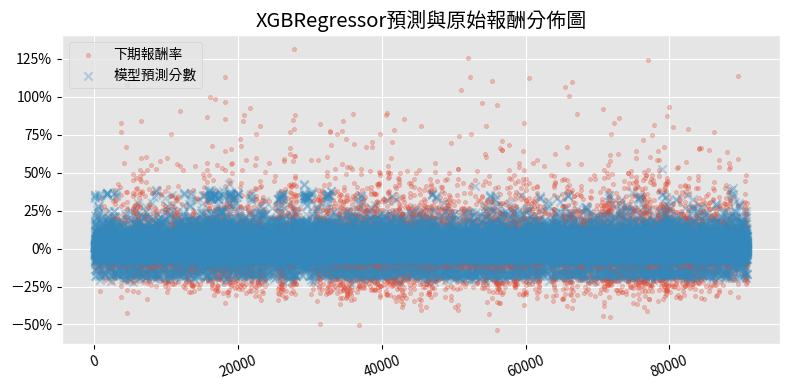

In [ ]:
df_train = df_feature_m[df_feature_m['資料日'] >= train_start_st]
df_train = df_train[df_train['資料日'] < test_start_st]
df_test = df_feature_m[df_feature_m['資料日'] >= test_start_st]
df_test = df_test[df_test['資料日'] <= test_end_dt]

##################
# 每期選幾檔股票(可調整)
portfolio_stock_num = 15
##################

# 模型訓練及選股
modelXGB = xgboost.XGBRegressor()
modelXGB.fit(df_train[feature_list],df_train['下期報酬率'])

df_test['模型預測分數'] = modelXGB.predict(df_test[feature_list])

MAE = mean_absolute_error(df_test['下期報酬率'],df_test['模型預測分數'])
print(MAE)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(df_test.index, df_test['下期報酬率'], label='下期報酬率',alpha=0.3,marker='.')
ax.scatter(df_test.index, df_test['模型預測分數'], label='模型預測分數',alpha=0.3,marker='x')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
plt.legend(loc='upper left')
plt.title('XGBRegressor預測與原始報酬分佈圖')
plt.xticks(rotation=20)
plt.tight_layout()

0.7060898870487875
0.5109630629111148


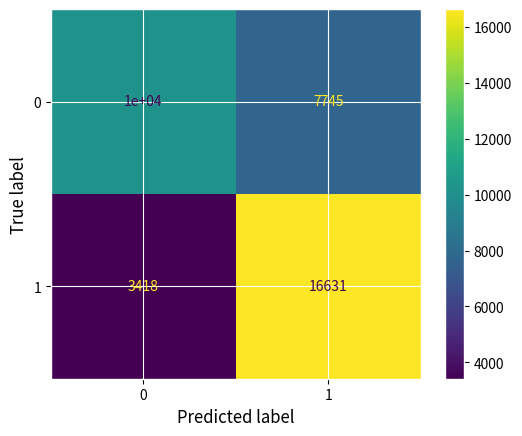

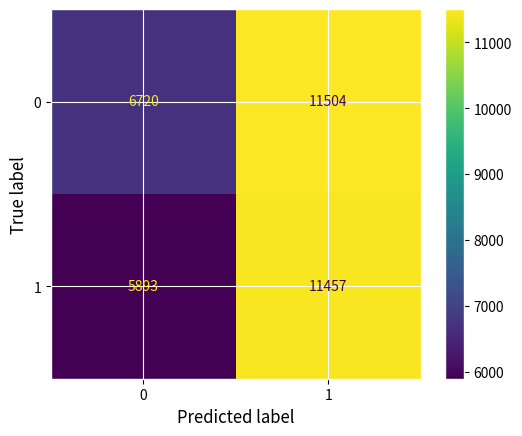

In [ ]:
df_feature=df_feature_m.drop(['證券名稱', '年月'],axis=1)
d_train = df_feature[df_feature['資料日'] >= train_start_st]
d_train = d_train[d_train['資料日'] < test_start_st]
d_test = df_feature[df_feature['資料日'] >= test_start_st]
d_test = d_test[d_test['資料日'] <= test_end_dt]

d_train = d_train.drop('資料日', axis=1)
d_test = d_test.drop('資料日', axis=1)

# 模型訓練及選股
# 訓練樣本再分成目標序列 y 以及因子矩陣 X
train_X = d_train.drop(['下期報酬','下期報酬率','收盤價'], axis=1)
train_y = d_train['下期報酬']
# 測試樣本再分成目標序列 y 以及因子矩陣 X
test_X = d_test.drop(['下期報酬','下期報酬率','收盤價'], axis=1)
test_y = d_test['下期報酬']

# 模型訓練
model = XGBClassifier(n_estimators=100,learning_rate=0.01,gamma=0.1)
model.fit(train_X, train_y)
# 繪製訓練集混淆矩陣
print(model.score(train_X,train_y))
ConfusionMatrixDisplay.from_estimator(model,train_X,train_y)
# 繪製測試集混淆矩陣
print(model.score(test_X,test_y))
ConfusionMatrixDisplay.from_estimator(model,test_X,test_y)

<Figure size 1000x4000 with 0 Axes>

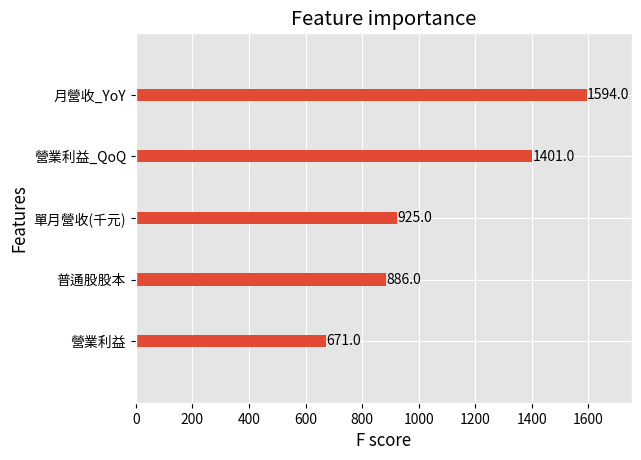

In [ ]:
plt.figure(figsize=(10,40))
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
df_test['模型預測報酬'] = model.predict(test_X)

MAE = mean_absolute_error(df_test['下期報酬'],df_test['模型預測報酬'])
print(MAE)

df_test = df_test.sort_values(['模型預測報酬','模型預測分數'],ascending=False)
df_select = df_test.groupby('資料日').apply(lambda x : x.head(portfolio_stock_num)).reset_index(drop=True)[['資料日','證券名稱','模型預測分數','模型預測報酬']]
df_select[df_select['資料日']=='2023-10-01']

0.4890369370888851


,資料日,證券名稱,模型預測分數,模型預測報酬
315,2023-10-01,2498宏達電,0.316530,1
316,2023-10-01,2915潤泰全,0.213967,1
317,2023-10-01,6625必應,0.130094,1
318,2023-10-01,1583程泰,0.121852,1
319,2023-10-01,2605新興,0.110456,1
320,2023-10-01,6446藥華藥,0.094093,1
321,2023-10-01,2330台積電,0.093073,1
322,2023-10-01,3682亞太電,0.092628,1
323,2023-10-01,2317鴻海,0.092399,1
324,2023-10-01,2382廣達,0.088398,1


# 5.0 投組績效回測

In [ ]:
# 讀取價格資料，進行整理
df = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//價量資料.feather')
df.sort_values(by=['證券名稱', '資料日'], ascending=True, inplace=True)
df.drop_duplicates(subset=['證券名稱', '資料日'], keep='last', inplace=True)
df['資料日'] = pd.to_datetime(df['資料日'])
df.set_index('資料日', inplace=True)
df.head()

,證券名稱,市場別,開盤價,最高價,最低價,收盤價,成交量(千股),成交金額(元),成交筆數,周轉率,流通在外股數(千股),個股市值(元),市值比重,成交金額比重,現金股利率(TEJ),本益比(TEJ),股價淨值比(TEJ),股價營收比(TEJ)
資料日,,,,,,,,,,,,,,,,,,
2018-01-02,1101台泥,TWSE,36.45,36.60,36.05,20.444681,13698.0,4.993709e+08,3932.0,0.3226,4246509.0,1.552099e+11,0.485348,0.522,3.45,20.26,1.38,1.63
2018-01-03,1101台泥,TWSE,36.50,37.35,36.25,20.892171,19959.0,7.373536e+08,5001.0,0.4700,4246509.0,1.586071e+11,0.491803,0.565,3.38,20.71,1.41,1.66
2018-01-04,1101台泥,TWSE,37.35,37.45,36.75,20.808266,14927.0,5.553930e+08,5698.0,0.3515,4246509.0,1.579701e+11,0.487705,0.414,3.39,20.62,1.41,1.65
2018-01-05,1101台泥,TWSE,37.50,37.50,37.05,20.864203,35536.0,1.325927e+09,7554.0,0.8368,4246509.0,1.583948e+11,0.487621,0.992,3.38,20.68,1.41,1.66
2018-01-08,1101台泥,TWSE,37.40,38.30,37.20,21.367628,22660.0,8.585742e+08,7513.0,0.5336,4246509.0,1.622166e+11,0.497755,0.659,3.30,21.18,1.45,1.70


## 5.1 選股投組回測

In [ ]:
# 每月初收盤價
monthly_st_price = df.groupby('證券名稱').resample('M')['收盤價'].first().unstack().transpose()

# 每月底收盤價
monthly_end_price = df.groupby('證券名稱').resample('M')['收盤價'].last().unstack().transpose()

# 這個月初到這個月底的報酬
monthly_returns = monthly_end_price/monthly_st_price - 1
# monthly_returns = monthly_end_price.pct_change()

print(monthly_returns.shape)
monthly_returns.head()

(71, 1759)


證券名稱,1101台泥,1102亞泥,1103嘉泥,1104環泥,1108幸福,1109信大,1110東泥,1201味全,1203味王,1210大成,...,9944新麗,9945潤泰新,9946三發地產,9949琉園,9950萬國通,9951皇田,9955佳龍,9958世紀鋼,9960邁達康,9962有益
資料日,,,,,,,,,,,,,,,,,,,,,
2018-01-31,0.030096,0.065603,0.007435,-0.006522,0.010714,0.026022,-0.044369,0.116390,0.057312,0.010401,...,0.002545,0.045313,-0.033457,-0.017857,0.003676,-0.116959,-0.068323,0.873391,-0.038514,0.014563
2018-02-28,-0.023747,-0.053333,-0.069853,-0.017505,-0.018935,0.032491,-0.003559,-0.056723,-0.022472,0.004438,...,0.010178,-0.028701,-0.015326,-0.031963,-0.054945,-0.042763,-0.105085,0.302083,-0.063291,0.028846
2018-03-31,-0.012162,0.012411,-0.075397,0.000000,-0.053528,-0.003521,0.003584,0.093960,0.003817,-0.011445,...,-0.015113,0.049231,0.031128,-0.018868,0.027132,-0.047945,0.022222,0.267717,0.035556,-0.018349
2018-04-30,0.114598,0.106272,0.004202,-0.015660,-0.011673,-0.014286,0.000000,-0.024845,-0.013410,0.103597,...,-0.015345,0.045455,0.069597,-0.004739,-0.065385,0.003597,0.003636,-0.105263,-0.046617,0.009174
2018-05-31,0.067319,0.031201,0.112971,-0.040909,0.061438,-0.007194,-0.007168,0.012712,0.005848,0.026490,...,-0.010390,0.004167,-0.017422,-0.038095,0.012097,-0.153571,-0.051095,-0.250000,-0.033762,-0.013575


In [ ]:
# 設定回測期間
start_dt = '2022-01-01'
end_dt = '2023-11-30'
# 換倉日
reb_date = df_select_m[(df_select_m['資料日'] > start_dt) & (df_select_m['資料日'] < end_dt)]['資料日'].unique()
reb_ticker=pd.DataFrame()
portfolio=pd.DataFrame()
# 計算投組每月報酬
portfolio_return = []
portfolio_stock_num=15
print(reb_date)
for i in range(len(reb_date)):

    reb_ticker_list = df_select_m[df_select_m['資料日'] == reb_date[i]]['證券名稱'].head(portfolio_stock_num).values
    reb_ticker = reb_ticker.append(df_select_m[df_select_m['資料日'] == reb_date[i]][['資料日','證券名稱','收盤價']].head(portfolio_stock_num))
    portfolio=portfolio.append((monthly_returns[reb_ticker_list].loc[reb_date[i] + MonthEnd(n=0)]).reset_index(name='月報酬',drop=False)[['證券名稱','月報酬']])
    '''
    for stock, weight in zip(monthly_returns[reb_ticker_list].loc[reb_date[i] + MonthEnd(n=0)]):
        portfolio=portfolio.append([[stock,weight]])
        '''
    #print((monthly_returns[reb_ticker_list].loc[reb_date[i] + MonthEnd(n=0)]).reset_index(name='月報酬',drop=False)[['證券名稱','月報酬']])
    #print((monthly_returns[reb_ticker_list].loc[reb_date[i] + MonthEnd(n=0)]).reset_index(name='月報酬',drop=True))
    mean_return = np.mean(monthly_returns[reb_ticker_list].loc[reb_date[i] + MonthEnd(n=0)])
    #print(reb_ticker)
    portfolio_return.append(mean_return)
    '''
    for stock, weight in zip([reb_ticker],[0.15, 0.15, 0.1, 0.1, 0.07, 0.07, 0.05, 0.05, 0.05, 0.05, 0.035, 0.035, 0.035, 0.035, 0.02]):
        stock['weighted daily return']=stock['收盤價']*weight
print(stock['weighted daily return'])
'''
#print(reb_ticker)
print(portfolio)

# 計算投組累積報酬
portfolio_return = np.insert(portfolio_return,0,[0]) #起始日報酬為0
portfolio_return = np.array(portfolio_return) + 1
print(portfolio_return)
portfolio_cumulative_return = portfolio_return.cumprod()
#勝率
win_rate = sum(1 for x in portfolio_return if (x-1) > 0) / len(reb_date)
print('win_rate',win_rate*100)
profit_factor = sum(1 for x in portfolio_return if (x-1) > 0) / abs(sum(1 for x in portfolio_return if (x-1) < 0))
print('profit_factor',profit_factor)
df_portfolio_tr = pd.DataFrame(index = np.insert(reb_date,0,reb_date[0]-MonthEnd(n=1)))
df_portfolio_tr['Portfolio Return'] = portfolio_return - 1
df_portfolio_tr['Portfolio Total Return'] = portfolio_cumulative_return
print(len(df_portfolio_tr))
df_portfolio_tr.head()

['2022-02-01T00:00:00.000000000' '2022-03-01T00:00:00.000000000'
 '2022-04-01T00:00:00.000000000' '2022-05-01T00:00:00.000000000'
 '2022-06-01T00:00:00.000000000' '2022-07-01T00:00:00.000000000'
 '2022-08-01T00:00:00.000000000' '2022-09-01T00:00:00.000000000'
 '2022-10-01T00:00:00.000000000' '2022-11-01T00:00:00.000000000'
 '2022-12-01T00:00:00.000000000' '2023-01-01T00:00:00.000000000'
 '2023-02-01T00:00:00.000000000' '2023-03-01T00:00:00.000000000'
 '2023-04-01T00:00:00.000000000' '2023-05-01T00:00:00.000000000'
 '2023-06-01T00:00:00.000000000' '2023-07-01T00:00:00.000000000'
 '2023-08-01T00:00:00.000000000' '2023-09-01T00:00:00.000000000'
 '2023-10-01T00:00:00.000000000' '2023-11-01T00:00:00.000000000']
        證券名稱       月報酬
0     1416廣豐  0.063348
1    1436華友聯 -0.023973
2   1438三地開發 -0.009772
3     1453大將 -0.037288
4   1472三洋實業 -0.226866
..       ...       ...
10    2025千興 -0.014103
11    2363矽統 -0.091760
12    2514龍邦  0.009524
13    2524京城  0.009677
14   2542興富發  0.008621

[330 ro

,Portfolio Return,Portfolio Total Return
2022-01-31,0.000000,1.000000
2022-02-01,-0.015700,0.984300
2022-03-01,0.037857,1.021563
2022-04-01,0.026841,1.048983
2022-05-01,0.016535,1.066328


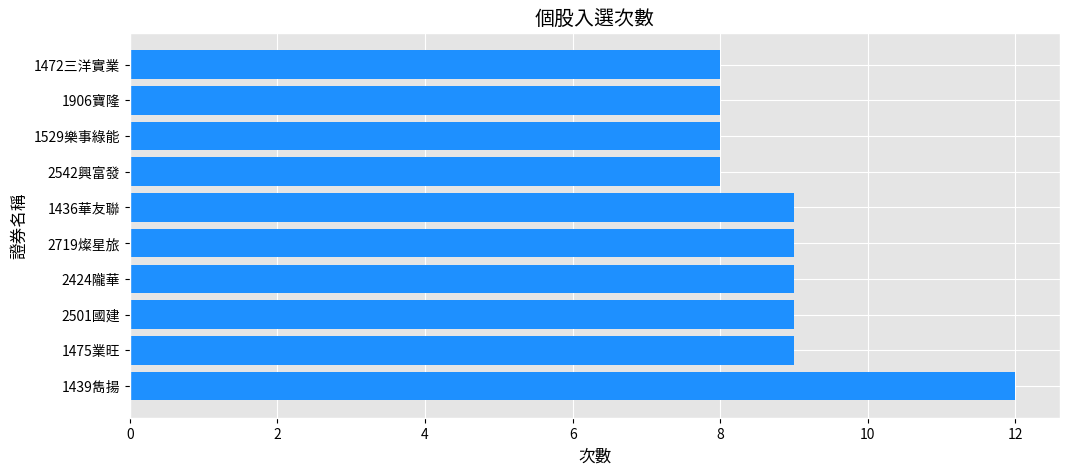

In [ ]:
freq = reb_ticker.groupby(['證券名稱'])['證券名稱'].count().reset_index(name='counts').sort_values('counts', ascending=False).head(10)
#print(p)
plt.figure(figsize=(12,5))
plt.title('個股入選次數')
plt.barh(freq['證券名稱'],freq['counts'],color=['dodgerblue'])
plt.ylabel('證券名稱')
plt.xlabel('次數')
plt.show()

       證券名稱        平均
89  2719燦星旅  0.243391
16   1453大將  0.230140
28   1538正峰  0.225115
95   2745五福  0.222481
23   1515力山  0.176251
30   1584精剛  0.163922
39   1781合世  0.162162
91  2734易飛網  0.135587
92   2739寒舍  0.128015
42   1799易威  0.117439


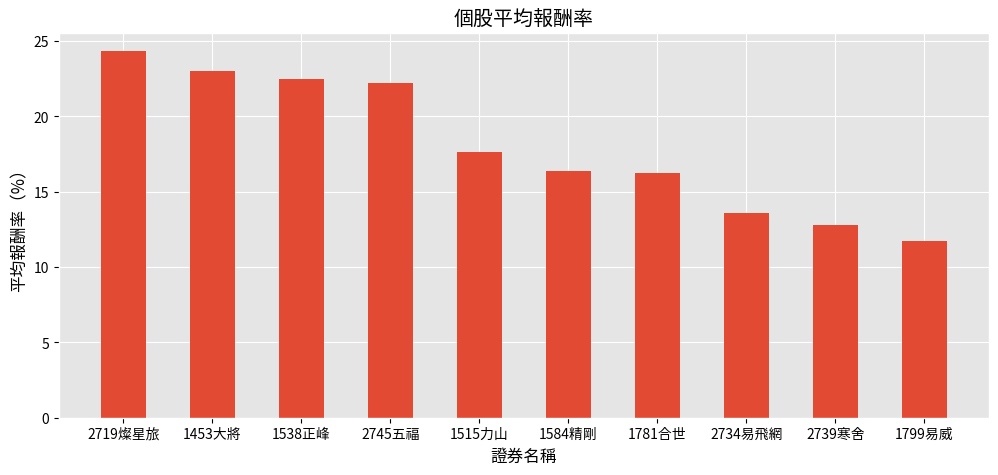

In [ ]:
avg = portfolio.groupby(['證券名稱'])['月報酬'].mean().reset_index(name='平均').sort_values('平均', ascending=False).head(10)
print(avg)
#print(p)
plt.figure(figsize=(12,5))
plt.title('個股平均報酬率')
plt.bar(avg['證券名稱'],avg['平均']*100, width=0.5)
plt.ylabel('平均報酬率（%）')
plt.xlabel('證券名稱')
plt.show()

       證券名稱        平均
60   2468華經 -0.293981
98  3535晶彩科 -0.270468
63  2491吉祥全 -0.164141
96  3085新零售 -0.154545
86   2705六福 -0.148749
37  1762中化生 -0.139116
40   1786科妍 -0.133570
46  2008高興昌 -0.122762
50  2359所羅門 -0.120219
3    1236宏亞 -0.115942


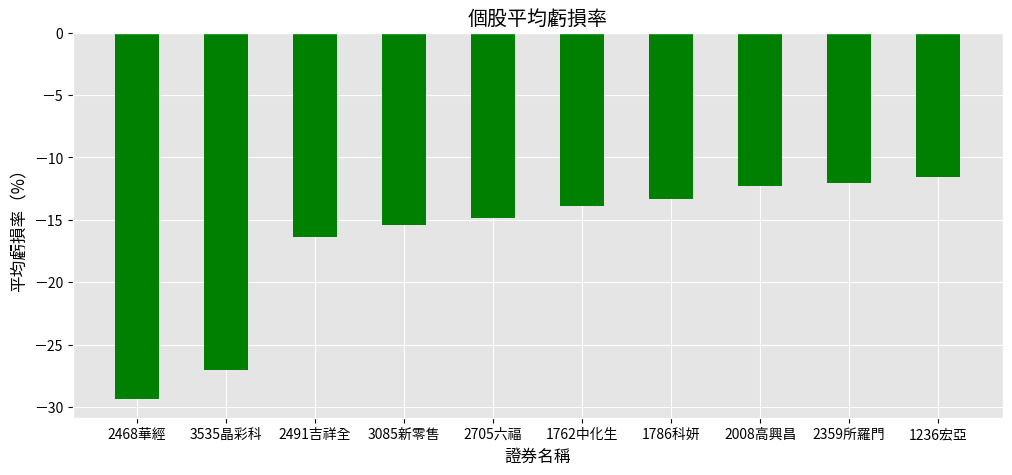

In [ ]:
avg = portfolio.groupby(['證券名稱'])['月報酬'].mean().reset_index(name='平均').sort_values('平均', ascending=True).head(10)
print(avg)
#print(p)
plt.figure(figsize=(12,5))
plt.title('個股平均虧損率')
plt.bar(avg['證券名稱'],avg['平均']*100,color=['green'], width=0.5)
plt.ylabel('平均虧損率（%）')
plt.xlabel('證券名稱')
plt.show()

       證券名稱        平均  counts
0    2468華經 -0.293981       1
1   3535晶彩科 -0.270468       1
2   2491吉祥全 -0.164141       1
3   3085新零售 -0.154545       1
4    2705六福 -0.148749       2
..      ...       ...     ...
94   1515力山  0.176251       2
95   2745五福  0.222481       2
96   1538正峰  0.225115       1
97   1453大將  0.230140       7
98  2719燦星旅  0.243391       9

[99 rows x 3 columns]


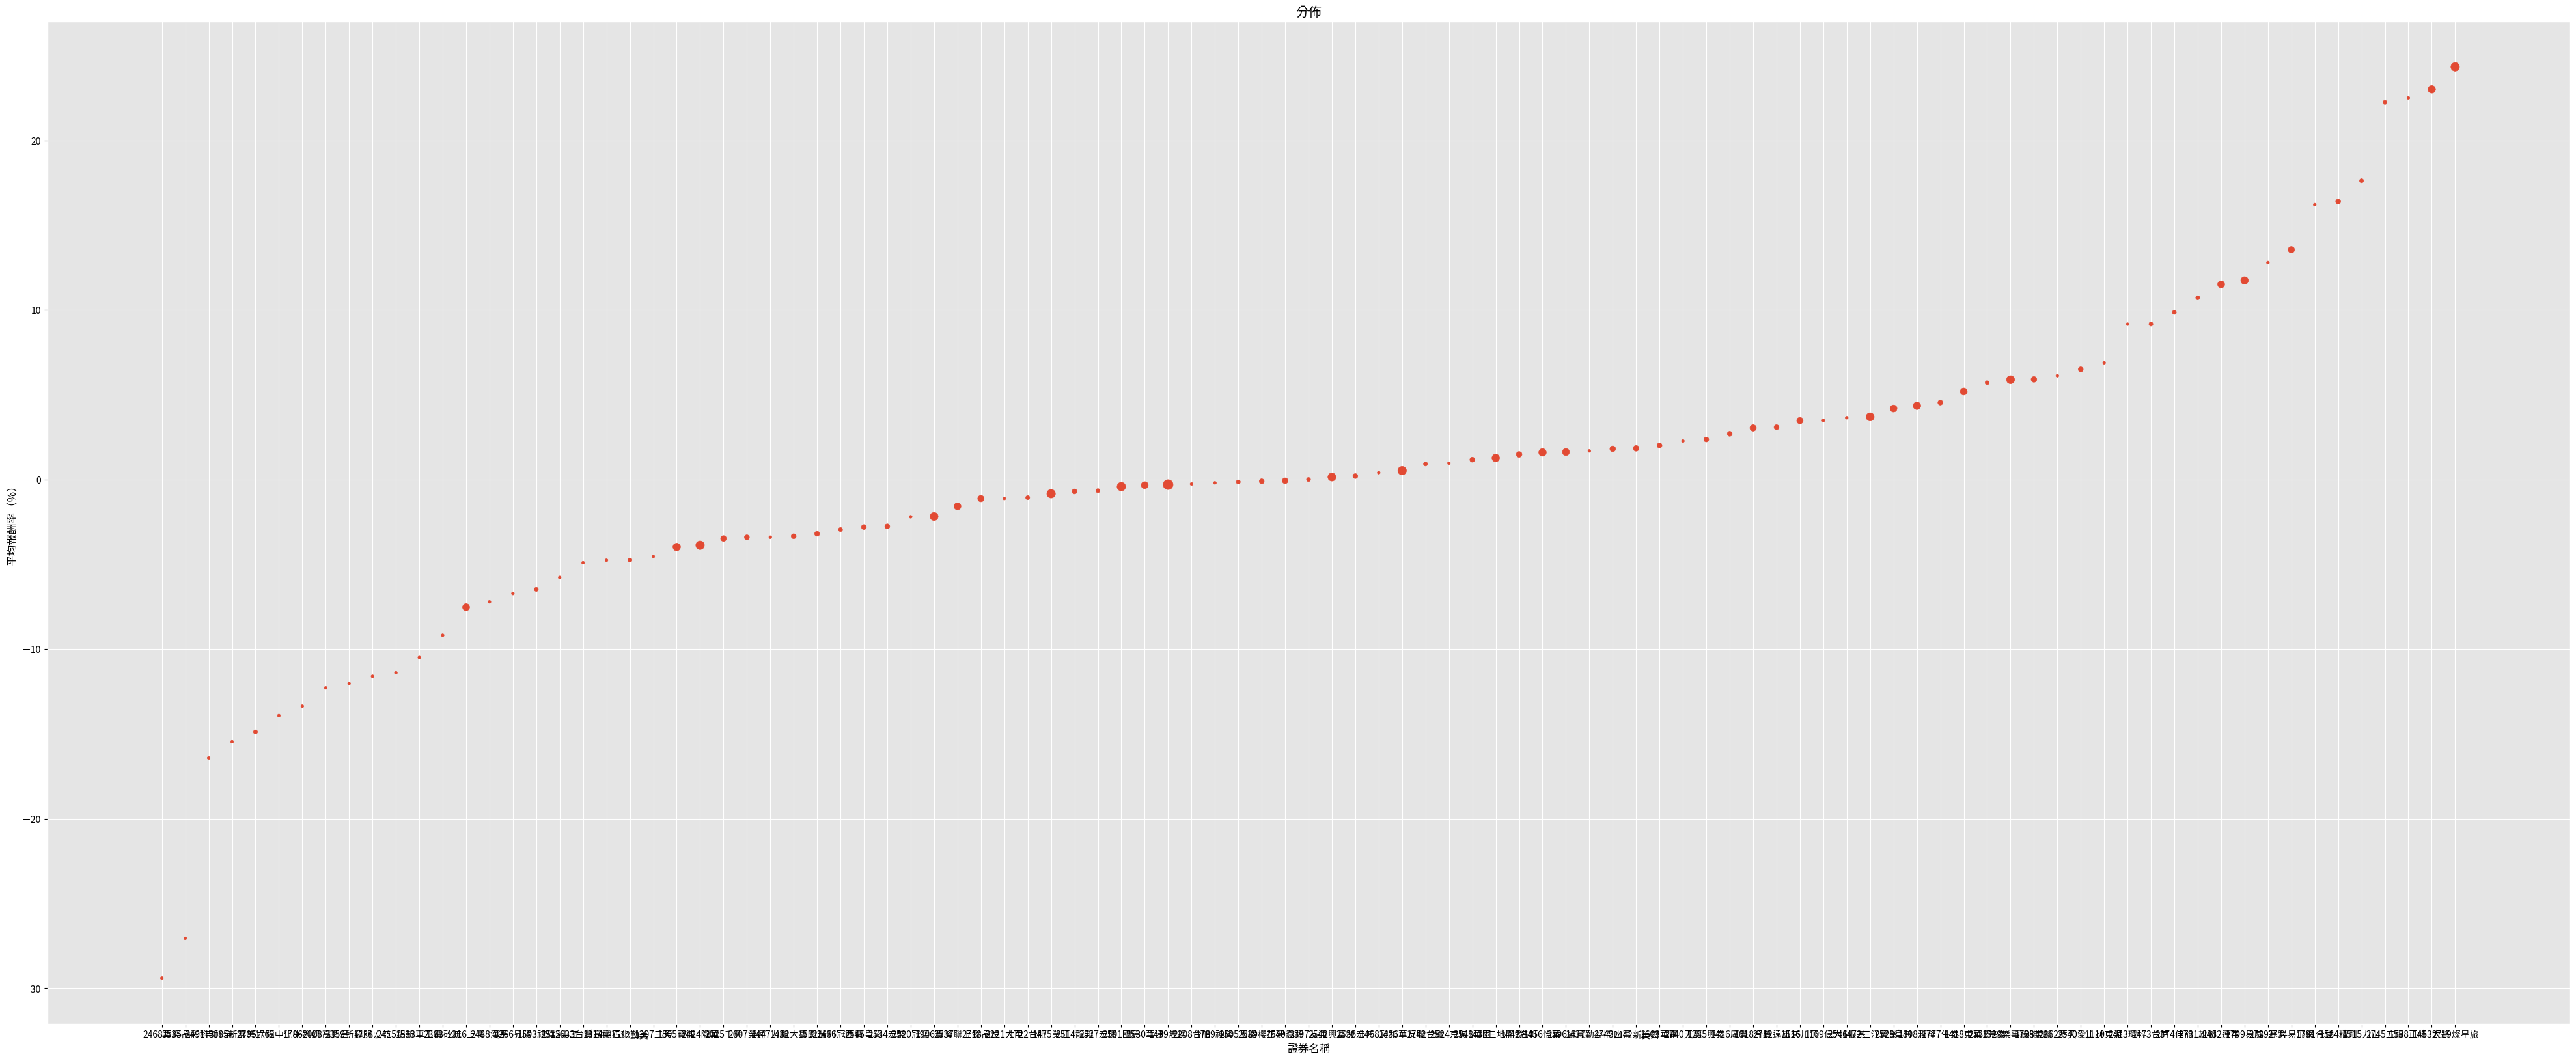

In [ ]:
avg = portfolio.groupby(['證券名稱'])['月報酬'].mean().reset_index(name='平均').sort_values('平均', ascending=True)
freq = reb_ticker.groupby(['證券名稱'])['證券名稱'].count().reset_index(name='counts').sort_values('counts', ascending=False)
all_freq=avg.merge(freq, "left", on=['證券名稱','證券名稱'])
print(all_freq)

plt.figure(figsize=(50,20))
plt.title('分佈')
plt.scatter(all_freq['證券名稱'],all_freq['平均']*100,all_freq['counts']*10)
plt.ylabel('平均報酬率（%）')
plt.xlabel('證券名稱')
plt.show()


## 5.2 加權報酬指數回測(Benchmark)

In [ ]:
# 讀取Benchmark資料
benchmark = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//加權報酬指數.feather')
benchmark.set_index('資料日',inplace=True)
benchmark.index = pd.to_datetime(benchmark.index)

# 每月初收盤價
monthly_st_price_bm = benchmark.resample('M')['收盤價'].first()
# 每月底收盤價
monthly_end_price_bm = benchmark.resample('M')['收盤價'].last()

# 這個月初到這個月底的報酬
# monthly_returns_bm = monthly_end_price_bm.pct_change()
monthly_returns_bm = monthly_end_price_bm/monthly_st_price_bm - 1
monthly_returns_bm = monthly_returns_bm.loc[[i + MonthEnd(n=0)for i in reb_date]]

# 計算Benchmark累積報酬
monthly_returns_bm = np.insert(np.array(monthly_returns_bm),0,[0]) #起始日報酬為0
monthly_returns_bm = np.array(monthly_returns_bm) + 1
bm_portfolio_tr = monthly_returns_bm.cumprod()

df_benchmark_tr = pd.DataFrame(index = np.insert(reb_date,0,reb_date[0]-MonthEnd(n=1)))
df_benchmark_tr['Benchmark Return'] = monthly_returns_bm - 1
df_benchmark_tr['Benchmark Total Return'] = bm_portfolio_tr
df_benchmark_tr

print(len(df_benchmark_tr))
df_benchmark_tr.head()

23


,Benchmark Return,Benchmark Total Return
2022-01-31,0.000000,1.000000
2022-02-01,-0.013786,0.986214
2022-03-01,-0.009513,0.976833
2022-04-01,-0.058098,0.920081
2022-05-01,0.018823,0.937400


## 績效呈現

,Portfolio Total Return,Benchmark Total Return
最大回撤,-0.227901,-0.191564
累積報酬,1.989333,1.058540
年化報酬,0.431685,0.030127
Sharpe Ratio,1.563262,0.153376


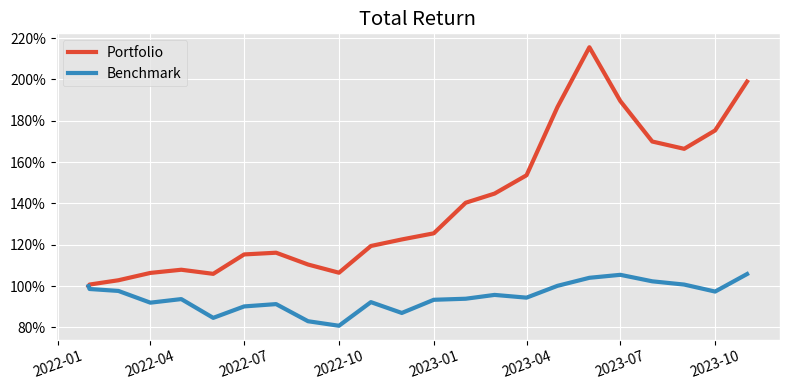

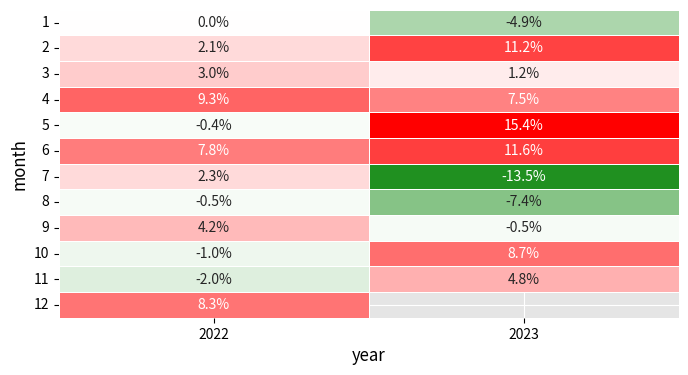

In [ ]:
# 績效指標
def perf_cal(df_tr, name_1, name_2):
    status = {}
    status['最大回撤'] = -((df_tr[name_1].cummax() - df_tr[name_1])/df_tr[name_1].cummax()).max()
    status['累積報酬'] = [df_tr[name_1].iloc[-1]]
    status['年化報酬'] = [(df_tr[name_1].iloc[-1] ** (12/len(df_tr))-1)]
    std = df_tr[name_2].std() * np.sqrt(12)
    status['Sharpe Ratio'] = status['年化報酬'] / std
    status = pd.DataFrame(status).transpose()
    status.columns = [name_1]
    return status

# 累積報酬圖
def plot_total_return(df_portfolio_tr,df_benchmark_tr, name):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(df_portfolio_tr.index, df_portfolio_tr['Portfolio Total Return'], label='Portfolio', linewidth=3)
    ax.plot(df_benchmark_tr.index, df_benchmark_tr['Benchmark Total Return'], label='Benchmark', linewidth=3)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
    plt.legend(loc='upper left')
    plt.title('Total Return')
    plt.xticks(rotation=20)
    plt.tight_layout()

# 月度勝率圖
def plot_monthly_return(df_portfolio_tr, df_benchmark_tr):
    df_portfolio_tr['year'] = df_portfolio_tr.index.year
    df_portfolio_tr['month'] = df_portfolio_tr.index.month
    df_benchmark_tr['year'] = df_benchmark_tr.index.year
    df_benchmark_tr['month'] = df_benchmark_tr.index.month
    rt_pivot_strategy = df_portfolio_tr.pivot(index='year', columns='month', values='Portfolio Return')
    rt_pivot_benchmark = df_benchmark_tr.pivot(index='year', columns='month', values='Benchmark Return')
    rt_pivot_excess = rt_pivot_strategy - rt_pivot_benchmark

    cmap1= LinearSegmentedColormap.from_list("custom", [(0, "green"), (0.5, "white"), (1, "red")])
    fig, ax = plt.subplots(figsize=(8,4))
    sns.heatmap(rt_pivot_excess.T,annot=True, xticklabels= True, yticklabels= True, cmap=cmap1, center=0, fmt='.1%', cbar=False, linewidths=0.5)
    plt.yticks(rotation=0)


# 呼叫績效呈現函式
plot_total_return(df_portfolio_tr,df_benchmark_tr, 'Portfolio_1')
plot_monthly_return(df_portfolio_tr, df_benchmark_tr)
portfolio_perf = perf_cal(df_portfolio_tr, 'Portfolio Total Return','Portfolio Return')
benchmark_perf = perf_cal(df_benchmark_tr, 'Benchmark Total Return','Benchmark Return')
summary_perf = pd.concat([portfolio_perf,benchmark_perf],axis=1)
summary_perf